<center>  <h1> Data 598 (Winter 2022): HW5 </h1> </center> 
    <center> University of Washington </center>
    
Please fill out all the `TODO`s in the notebook below. 

# Coding up a differentiable module

Consider the soft-thresholding function $f_T: \mathbb{R} \to \mathbb{R}$ defined for any $T > 0$ as 
$$
    f_T(y) = 
    \begin{cases} 
        0, & \text{ if } -T \le y \le T \,, \\
        y - T, & \text{ if } y > T \,, \\
        y + T, & \text{ if } y < T \,.
    \end{cases}
$$

See the image below for $T=3$. 
<img src="https://d3i71xaburhd42.cloudfront.net/32c265c127e6985e365b93158123655e13768ea4/6-Figure2-1.png" width="300">



**A)** Write a function to compute which takes in as arguments $y, T$ and returns the soft-thresholding $f_T(y)$.
    Plot this function with $T = 3.14$ in the range $[-10, 10]$.

In [1]:
import numpy as np
import torch

# Example of PyTorch Scalar
x = torch.tensor(3.14159, requires_grad=True)
print(x)

tensor(3.1416, requires_grad=True)


In [9]:
import matplotlib.pyplot as plt
def softt(y, T):
    """ `y` is a torch.tensor (i.e., PyTorch's scalar type; same as above), 
        `T` is a regular Python number (float or int).
        return type: torch.tensor
    """
    if y > T:
        return torch.add(y, -T)
    elif y < -T:
        return torch.add(y, T)
    else:
        return torch.zeros_like(y, requires_grad=True)

**B)** Write a function which computes the derivate $f_T'(y)$ of the soft-thresholding function w.r.t. $y$, as returned by PyTorch. Plot this for $T=3.14$ in the range $[-10, 10]$. 

**Hint 1**: If you coded up `softt` using branches, you might encounter a situation where the output does not depend on the input. In this case, you will have to appropriately set the `allow_unused` flag. 

**Hint 2**: When PyTorch returns a derivative of `None`, it actually stands for `0`. If your derivative returns a `None`, you will have to handle this appropriately when plotting the function.

(tensor(0.),)


Text(0.5, 1.0, 'Soft thresholding derivative with $T=3.14$')

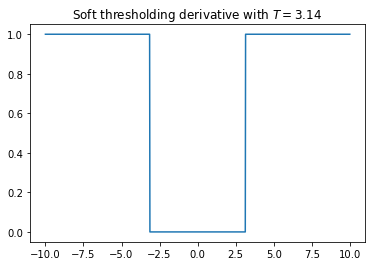

In [3]:
def softt_derivative(y, T): 
    # TODO: your code here
    # Call torch.autograd.grad to compute the derivative
    f = softt(y, T)
    grad = torch.autograd.grad(outputs=f, inputs=y, allow_unused=True)
    return grad

# Test your code
a = torch.tensor(1.2, requires_grad=True)
print(softt_derivative(a, 1.2))

# Plot
# TODO: your code here
ys = torch.linspace(-10, 10, 1000, requires_grad=True)
grads = [softt_derivative(y, 3.14)[0] if softt_derivative(y, 3.14)[0] is not None else 0 for y in ys]
plt.plot(ys.detach().numpy(), np.asarray(grads))
plt.title('Soft thresholding derivative with $T=3.14$')

**C)** We will now code a differentiable module using `torch.nn.Module`. 

First, let us extend the definition of 
the soft-thresholding $f_T$ to vectors by applying the soft-thresholding operation component-wise. 

Now write a differentiable module which implements the transformation $g_{T}(x, A; M)$ given by 
$$
    g_{T}(x, A; M) = M^{-1} \, f_T\big( (A^{-1} A)^n  Mx \big) \,,
$$

where $n=10000$ is given. Note that we can simplify $ A^{-1} A = I$ to obtain the same result. However, our chain (going right to left) contains the repetitive and unnecessary computation of multiplying $Mx$ by $A$ and then immediately undoing it by multiplying by $A^{-1}$. 

Note that $x \in \mathbb{R}^d$ is a vector, $A \in \mathbb{R}^{d\times d}$ is an invertible matrix and the output is a vector is a vector in $\mathbb{R}^d$.

Here, $M \in \mathbb{R}^{d \times d}$, a symmetric matrix, is a *parameter* of the module. (Recall: parameters maintain state of the module; register a parameter in `torch.nn.Module` by using the `torch.nn.Parameter` wrapper).

Supply $T > 0$ and and initial value $M_0 \in \mathbb{R}^{d \times d}$ symmetric to the constructor, while the `forward` method only accepts $x \in \mathbb{R}^d$ as an input. 

You may use the function `create_symmetric_invertible_matrix` to initialize this matrix `M` in the constructor.

In [12]:
class WastefulMatmulSofttMatmulinv(torch.nn.Module):
    #### TODO: your code here
    def __init__(self, M, T, n):
        super().__init__()
        self.M = torch.nn.Parameter(M)
        self.T = T
        self.n = n
    
    def forward(self, x, A):
        res = torch.matmul(self.M, x)
        for _ in range(self.n):
            res = torch.matmul(A, res)
            res = torch.matmul(torch.linalg.inv(A), res)
        f_T = torch.tensor([softt(y, self.T) for y in res])
        g_T = torch.matmul(torch.linalg.inv(self.M), f_T)
        return g_T

**D)** Initialize the module with $T = 3.14$ and $M_0$ using the function `create_symmetric_invertible_matrix` with `seed=0`.  
Use `dimension=5`. Pass in the following vector `x` and matrix `A` defined below and compute $g_T(x, A;M_0)$.

In [13]:
import numpy as np
def create_symmetric_invertible_matrix(dimension, seed=0):
    # return symmetric invertible square matrix of size `dimension` x `dimension`
    rng = np.random.RandomState(dimension + seed)
    factor = rng.randn(dimension, dimension)  # use dtype double
    return 1e-6 * torch.eye(dimension) + torch.from_numpy(np.matmul(factor, factor.T))

dimension = 5
x = torch.DoubleTensor([0.1, 5, -2.3, -1, -2]).requires_grad_(True)  # use dtype double
A = create_symmetric_invertible_matrix(dimension, seed=10).requires_grad_(True)
print('x:', x)
# TODO: your code here using `WastefulMatmulSofttMatmulinv`
M = create_symmetric_invertible_matrix(dimension, seed=0)
wasteful = WastefulMatmulSofttMatmulinv(M, 3.14, 10000)
g = wasteful(x, A)
print(f'g_T(x, A; M_0) = {g}')

x: tensor([ 0.1000,  5.0000, -2.3000, -1.0000, -2.0000], dtype=torch.float64,
       requires_grad=True)
g_T(x, A; M_0) = tensor([-0.6328,  6.8930, -0.5180,  1.2438, -0.6816], dtype=torch.float64,
       grad_fn=<MvBackward0>)


**E)** For the same vector `x` as defined above, compute and print out the gradient of $\varphi_T(x, A; M) = \|x - g_T(x, A; M)\|_2^2$
with respect to $x$, $A$, and $M$ using automatic differentiation. Use $T=3.14$ again.

Time the computation of the gradient using Python's `time` module. 

In [16]:
import time 
# TODO: your code here
start = time.time()
wasteful = WastefulMatmulSofttMatmulinv(M, 3.14, 10000)
f_wasteful = wasteful(x, A)
norm_wasteful = torch.linalg.norm(x - f_wasteful)**2
grad_wasteful = torch.autograd.grad(outputs=norm_wasteful, inputs=[x, A], allow_unused=True)
end = time.time()

print(f'Total time: {end - start}')

Total time: 0.38019371032714844


**F)** Repeat parts C-E above but with an efficient version of `WastefulMatmulSofttMatmulinv` that utilizes the simplification $A^{-1} A = I$ to return the exact same output. 

Note how much time the computation of the gradient takes. Why do you observe the discrepancy in the run times? Do you observe any discrepancy in the gradients? If yes, why? 

**Hint**: Set the flag `allow_unused=True` in the call to `torch.auto.grad`. 

In [24]:
class EfficientMatmulSofttMatmulinv(torch.nn.Module):
    #### TODO: your code here
    def __init__(self, M, T, n):
        super().__init__()
        self.M = torch.nn.Parameter(M)
        self.T = T
        self.n = n
    
    def forward(self, x, A):
        res = torch.matmul(self.M, x)
        f_T = torch.tensor([softt(y, self.T) for y in res])
        g_T = torch.matmul(torch.linalg.inv(self.M), f_T)
        return g_T

In [25]:
# TODO: your code here with EfficientMatmulSofttMatmulinv
import time
start = time.time()
efficient = EfficientMatmulSofttMatmulinv(M, 3.14, 10000)
f_efficient = efficient(x, A)
norm_efficient = torch.linalg.norm(x - f_efficient)**2
grad_efficient = torch.autograd.grad(outputs=norm_efficient, inputs=[x, A], allow_unused=True)
end = time.time()

print(f'Total time: {end - start}')

Total time: 0.0510401725769043


There is a discrepancy in runtimes because in the efficient version of the module, we are forgoing the n number of reptitions of calculating $I$ via $A^TA$.  

In [29]:
# TODO: check the difference of gradients from EfficientMatmulSofttMatmulinv and WastefulMatmulSofttMatmulinv
torch.diff(grad_efficient[0], grad_wasteful[0])

TypeError: diff(): argument 'n' (position 2) must be int, not Tensor

In [31]:
grad_efficient[0] - grad_wasteful[0]

tensor([ 2.0632e-11, -9.3076e-11, -5.1182e-11, -7.7318e-11, -3.2657e-11],
       dtype=torch.float64)

There is not a big difference between the gradients for the efficient and wasteful modules.